# Mass balance
## Case 2: Pressure in Single Tank
### Author: Bernt Lie, University of South-Eastern Norway
### Date: February 8, 2023
#### Installing packages

In [1]:
using ModelingToolkit
using DifferentialEquations
using Plots, LaTeXStrings

##### Constants

In [2]:
# Specifying line properties as constants makes it possible to globally 
# change these values and keep consistency
LW1 = 2.5
LC1 = :red
LC2 = :blue
LC3 = :green

figpath = "C:/Users/Bernt/OneDrive/Documents/booksBLSOL/ModDynSyst/figs/"
figtype = ".svg"
SAVEFIG = true
;

#### Gas tank
Variables, parameters, and differentiaton operator:

In [3]:
@variables t m(t) md_i(t) md_e(t) n(t) p(t) dp_i(t) p_i(t) dp_e(t)
@parameters V M R T K_i p_ς K_e p_a
Dt = Differential(t)
;

##### Symbolic model
First, we symbolically define the input driving pressure `u_p`:

In [4]:
@register_symbolic u_p(t)
;

In [5]:
eqs = [Dt(m) ~ md_i-md_e,
        m ~ n*M,
        p*V ~ n*R*T,
        dp_i ~ p_i - p,
        dp_e ~ p - p_a,
        md_i ~ K_i*sqrt(dp_i/p_ς),
        md_e ~ K_e*sqrt(dp_e/p_ς),
        p_i ~ u_p(t)]

@named tank = ODESystem(eqs)

Model tank with 8 equations
States (8):
  m(t)
  md_e(t)
  md_i(t)
  n(t)
⋮
Parameters (8):
  M
  V
  R
  T
⋮

##### Simplification and index reduction

In [6]:
tank_simp = structural_simplify(tank)

Model tank with 1 equations
States (1):
  m(t)
Parameters (8):
  M
  V
  R
  T
⋮
Incidence matrix:1×2 SparseArrays.SparseMatrixCSC{Num, Int64} with 2 stored entries:
 ×  ×

Note that this simplified model apparently has $m$ as state and $h$ on the right hand side (here, *matrix* $M=1$). Clearly, this is not a complete model - the equation does not show the relationship between $m$ and $h$!
However, the key thing to understand from the above equation is that we (i) need to provide initial value for $m$ (since the equation shows the time derivative of $m$), and (ii) the relationship between $m$ and $h$ is still there, but it is hidden. Requesting the `full_equations` for the model gives:

In [7]:
full_equations(tank_simp)

1-element Vector{Equation}:
 Differential(t)(m(t)) ~ K_i*sqrt(((-R*T*m(t)) / (M*V) + u_p(t)) / p_ς) - K_e*sqrt(((R*T*m(t)) / (M*V) - p_a) / p_ς)

This form of the model is in state space form. In addition, the system keeps track of observed variables = the remaining unknowns.

##### States and parameters

We can also inspect *states* and *parameters*:

In [8]:
states(tank_simp)

1-element Vector{Any}:
 m(t)

In [9]:
parameters(tank_simp)

8-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 M
 V
 R
 T
 p_a
 K_i
 p_ς
 K_e

##### Specifying parameters, operating conditions, and time span

We will use both a constant value for `p_i`, and a step change to find response to a step in `p_i` from steady state.

In [10]:
pi_const(t) = 10*1.03e5
pi_step(t) = t<25 ? 10*1.03e5 : 12*1.03e5
;

In [11]:
# Parameters
par = [R=>8.31, M=>28, p_a=>1.03e5, p_ς=>1.03e5, V=>50e-3, K_i=>3, K_e=>3, T=>300]
# Operating conditions
p0 = 1.2*1.03e5
x0 = [m => p0*V/(R*T)*M] # Specifying initial state(s)
u_p(t) = pi_const(t)   # Specifying input function(s)
# Time span
tspan = (0.0,150)   # Specifying tuple of initial and final time -- must be floating point
;

##### Creating numeric model, and solving the model

In [12]:
prob = ODEProblem(tank_simp, x0, tspan, par)

sol = solve(prob,Tsit5());

##### Storing plot of the pressure with constant input

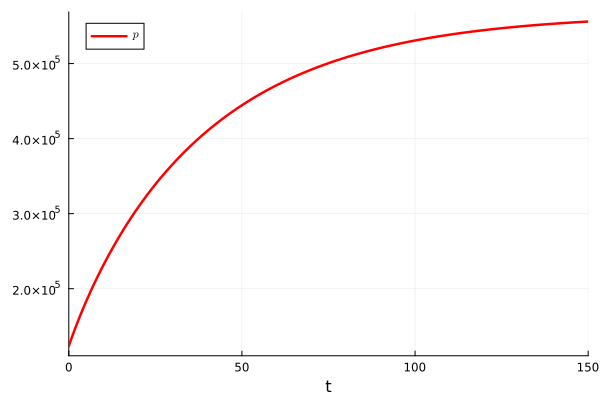

In [13]:
plot(sol,idxs=p,lw=LW1,lc=LC1,label=L"p")

What if we would like to scale the response to be in atm?

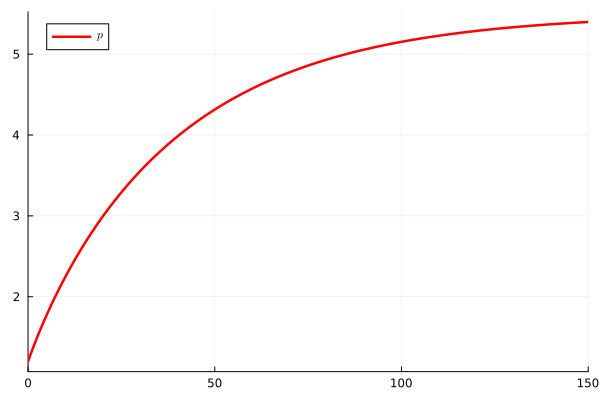

In [14]:
fg = plot(sol,idxs=p/1.03e5,lw=LW1,lc=LC1,xlabel="",label=L"p")

We could perhaps also want to show the abscissa/time axis in *minutes* instead of seconds. This can be done as follows:

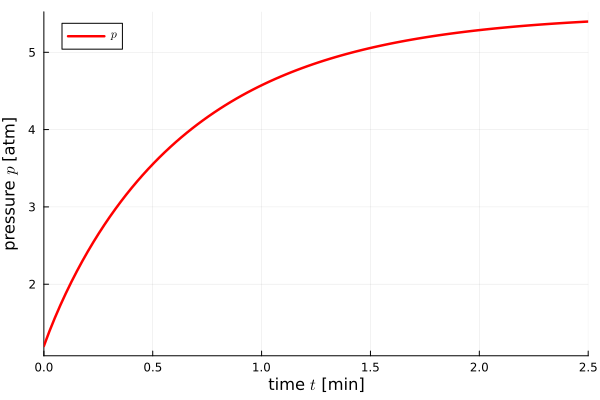

In [15]:
# plot(sol,idxs=[p/1.03e5,p_i/1.03e5],lw=LW1,lc=LC1,xlabel="",label=L"p")

tm = range(tspan...,length=100)
plot(sol.(tm,idxs=t)/60, sol.(tm,idxs=p)/1.03e5, lw=LW1,lc=LC1,xlabel="",label=L"p")
plot!(xlabel=L"time $t$ [min]", ylabel=L"pressure $p$ [atm]", xlims = tspan./60)

##### Finding steady state pressure
We assume that steady state is reached after 10_000 seconds.

In [16]:
tspan = (0.0,10_000)   # Specifying tuple of initial and final time -- must be floating point
prob = ODEProblem(tank_simp, x0, tspan, par)
sol = solve(prob,Tsit5())

m_ss = sol[end][1]
;

##### Step response from steady state

In [17]:
# Parameters
#... as before
# Operating conditions
x0 = [m => m_ss] # Specifying initial state(s)
u_p(t) = pi_step(t)   # Specifying input function(s)
# Time span
tspan = (0.0,150)   # Specifying tuple of initial and final time -- must be floating point

prob = ODEProblem(tank_simp, x0, tspan, par)
sol = solve(prob,Tsit5());

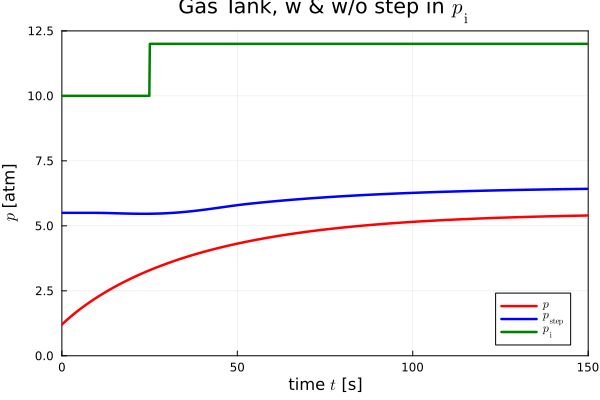

In [18]:
plot!(fg,sol,idxs=[p/1.03e5,p_i/1.03e5],lw=LW1,lc=[LC2 LC3], xlabel="",
    label=[L"p_\mathrm{step}" L"p_\mathrm{i}"])
plot!(title=L"Gas Tank, w & w/o step in $p_\mathrm{i}$", xlabel=L"time $t$ [s]",ylabel=L"$p$ [atm]")
plot!(framestyle =:box, grid=true,ylims=(0,12.5))

In [19]:
if SAVEFIG
    figname = "gasTankSim"
    savefig(figpath*figname*figtype)
end
;